# Using Classification Models to Predict Which Reddit Page a Submission Came From

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Cleaning and EDA

In [2]:
phil = pd.read_csv('../data/askphil.csv')
phil.drop(columns = 'Unnamed: 0', inplace = True)
phil.head()

,selftext,title,subreddit
0,NaN,What would your first official act be if you r...,askphilosophy
1,Can’t find anything from Google. There was an ...,Does anyone have the review of Camus’ The Rebe...,askphilosophy
2,I'm need to describe how they would handle foo...,What are characteristics of Ecological Constru...,askphilosophy
3,"I can see how this cause would be eternal, nec...",How does the contingency argument show that th...,askphilosophy
4,What was once a precious guideline has been di...,"From my very limited perspective, philosophy a...",askphilosophy


In [3]:
relig = pd.read_csv('../data/relig.csv')
relig.drop(columns = 'Unnamed: 0', inplace = True)
relig.head()

,selftext,title,subreddit
0,"In some Buddhist texts, Buddhas are referred t...","Why the Buddha is called ""god over the gods""",religion
1,Hi! As a Hellenic polytheist with Christian pa...,My mom confronting me on my altar.,religion
2,\n\nI was having a friendly discussion with a...,Does the act of looking for evidence of god’s ...,religion
3,[removed],Interreligious marriage,religion
4,NaN,"⚠️Persecution Exists Today, For Minorities Reg...",religion


In [4]:
all_posts = pd.concat([phil, relig], ignore_index=True)
all_posts.shape

(5989, 3)

In [5]:
all_posts.isnull().sum()

selftext     1252
title           0
subreddit       0
dtype: int64

In [6]:
null_rows = all_posts[all_posts['selftext'].isna()]

In [7]:
null_rows.shape

(1252, 3)

In [8]:
null_rows['subreddit'].value_counts(normalize=True)

religion         0.634185
askphilosophy    0.365815
Name: subreddit, dtype: float64

In [9]:
all_posts = all_posts.fillna('')

In [10]:
all_posts.isnull().sum()

selftext     0
title        0
subreddit    0
dtype: int64

Because roughly 20% of our data had a null value for self text, we didn't want to drop all the rows that had null values. Instead, we replaced null values with an empty string. There might be a pattern in which subreddit is more likely to only have a title and not submission text, and so we wanted to leave these instances in represented by only an empty string. 

In [11]:
all_posts['subreddit'] = all_posts['subreddit'].map({'askphilosophy': 0, 'religion': 1})

In [12]:
all_posts.head()

,selftext,title,subreddit
0,,What would your first official act be if you r...,0
1,Can’t find anything from Google. There was an ...,Does anyone have the review of Camus’ The Rebe...,0
2,I'm need to describe how they would handle foo...,What are characteristics of Ecological Constru...,0
3,"I can see how this cause would be eternal, nec...",How does the contingency argument show that th...,0
4,What was once a precious guideline has been di...,"From my very limited perspective, philosophy a...",0


In [13]:
#check for and remove duplicated posts 
all_posts.duplicated().sum()

65

In [14]:
all_posts = all_posts.drop_duplicates(keep = 'first')

In [15]:
all_posts.duplicated().sum()

0

In [16]:
removed_rows = all_posts[all_posts['selftext'] == '[removed]']

In [17]:
removed_rows.head()

,selftext,title,subreddit
33,[removed],Is it wrong to to use these terms?,0
35,[removed],Is it wrong to call people fools?,0
70,[removed],What is wrong with this point of view: the onl...,0
139,[removed],Is materialism a lind of platonism?,0
150,[removed],would this be a valid deductive argument.,0


In [18]:
removed_rows.shape

(979, 3)

In [19]:
removed_rows['subreddit'].value_counts(normalize = True)

1    0.835546
0    0.164454
Name: subreddit, dtype: float64

Unfortunately removing all the rows where the text has been removed does create more unbalanced classes, and it is a big chunk of our data, but we purposefully pulled more submissions than needed from each subreddit so we could drop rows if necessary during cleaning. There is no good way to impute values for these removed text rows and so we are going to drop them. 

In [20]:
all_posts = all_posts[all_posts['selftext'] != '[removed]']

In [21]:
all_posts.shape

(4945, 3)

## EDA

In [22]:
all_posts['status_length'] = all_posts['selftext'].str.len()
all_posts.head()

,selftext,title,subreddit,status_length
0,,What would your first official act be if you r...,0,0
1,Can’t find anything from Google. There was an ...,Does anyone have the review of Camus’ The Rebe...,0,308
2,I'm need to describe how they would handle foo...,What are characteristics of Ecological Constru...,0,112
3,"I can see how this cause would be eternal, nec...",How does the contingency argument show that th...,0,94
4,What was once a precious guideline has been di...,"From my very limited perspective, philosophy a...",0,123


In [23]:
all_posts['status_word_count'] = all_posts['selftext'].str.count(' ').add(1)
all_posts.head()

,selftext,title,subreddit,status_length,status_word_count
0,,What would your first official act be if you r...,0,0,1
1,Can’t find anything from Google. There was an ...,Does anyone have the review of Camus’ The Rebe...,0,308,52
2,I'm need to describe how they would handle foo...,What are characteristics of Ecological Constru...,0,112,20
3,"I can see how this cause would be eternal, nec...",How does the contingency argument show that th...,0,94,17
4,What was once a precious guideline has been di...,"From my very limited perspective, philosophy a...",0,123,19


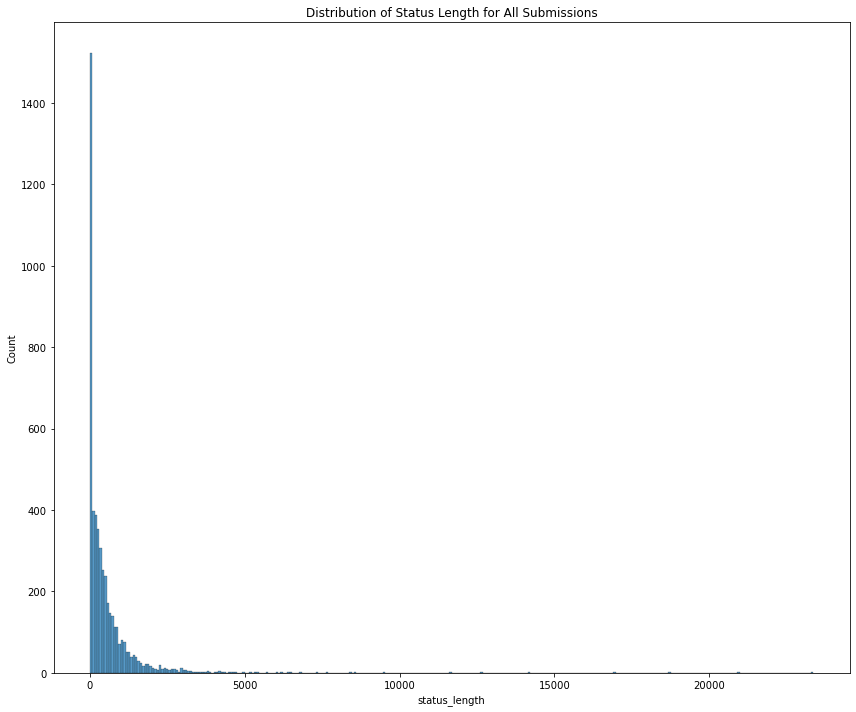

In [24]:
plt.figure(figsize = (12,10))
sns.histplot(data = all_posts["status_length"] )
plt.title('Distribution of Status Length for All Submissions')
plt.tight_layout()
plt.savefig('../visualizations /dist_sl_all.jpg', bbox_inches = 'tight');

This histogram shows the distribution of status lengths for all the posts we pulled from both subreddits. The distribution is skewed to the right, ranges from 0 to over 20,000, and has a clear mode of 0. 

In [25]:
all_posts['status_length'].describe()

count     4945.000000
mean       528.678059
std        999.546997
min          0.000000
25%          0.000000
50%        264.000000
75%        655.000000
max      23361.000000
Name: status_length, dtype: float64

In [26]:
all_posts[all_posts['status_length']>=23361]

,selftext,title,subreddit,status_length,status_word_count
3878,*The purpose of this piece is not to be scient...,An inadequate attempt to create an abstract mo...,1,23361,3842


In [27]:
all_posts['status_length'].value_counts()

0       1239
9         19
5         15
134       11
111       11
        ... 
1119       1
1617       1
1696       1
538        1
1868       1
Name: status_length, Length: 1486, dtype: int64

In [28]:
no_st = all_posts[all_posts['status_length'] == 0]
no_st['title_len'] = no_st['title'].str.len()
no_st['title_len'].value_counts(ascending = True)

/var/folders/r1/szl7szs91f5bkjddv3cxyk8r0000gn/T/ipykernel_2226/289705509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_st['title_len'] = no_st['title'].str.len()


180     1
278     1
7       1
287     1
292     1
       ..
47     17
58     17
53     18
43     18
60     20
Name: title_len, Length: 242, dtype: int64

In [29]:
no_st['subreddit'].value_counts(normalize= True)

1    0.630347
0    0.369653
Name: subreddit, dtype: float64

There are 1,239 posts with no selftext (the body of the reddit post), but all of them have a title. Because of this (and our plan to count vectorize a concatenated string of text and title), we will not be dropping any of the posts with no self text because the title still could be helpful in building a model to classify the subreddit that a submission came from.

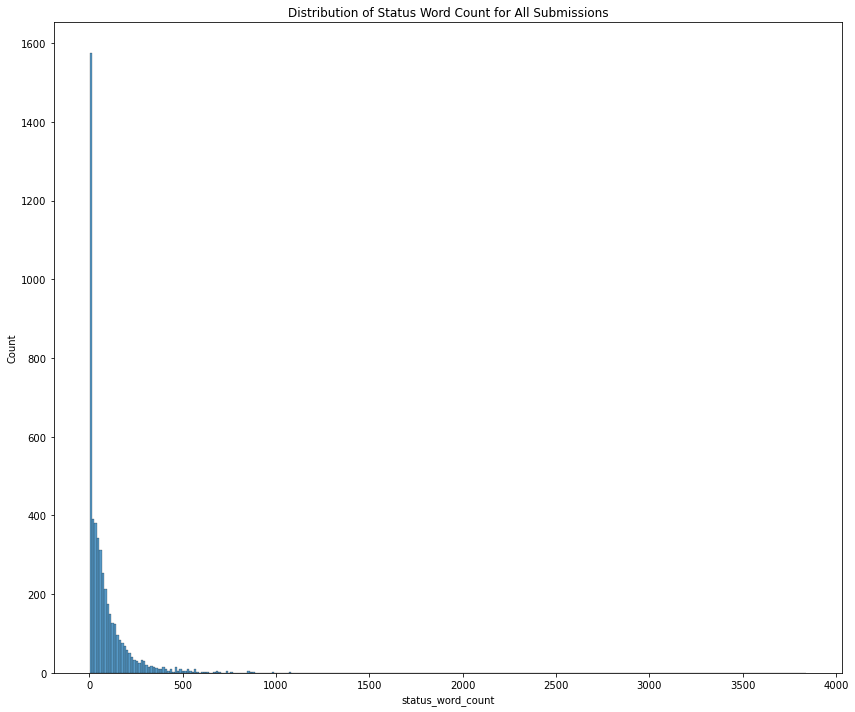

In [30]:
plt.figure(figsize = (12,10))
sns.histplot(data = all_posts["status_word_count"] )
plt.title('Distribution of Status Word Count for All Submissions')
plt.tight_layout()
plt.savefig('../visualizations /dist_swc_all.jpg', bbox_inches = 'tight');

In [31]:
all_posts['status_word_count'].describe()

count    4945.000000
mean       89.939939
std       165.881850
min         1.000000
25%         1.000000
50%        45.000000
75%       112.000000
max      3842.000000
Name: status_word_count, dtype: float64

This histogram shows the distribution of status word counts for all the posts we pulled from both subreddits. The distribution is skewed to the right, ranges from 0 to over 3500, and has a clear mode of 0. 

In [32]:
all_posts['title_len'] = all_posts['title'].str.len()
all_posts.head()

,selftext,title,subreddit,status_length,status_word_count,title_len
0,,What would your first official act be if you r...,0,0,1,61
1,Can’t find anything from Google. There was an ...,Does anyone have the review of Camus’ The Rebe...,0,308,52,91
2,I'm need to describe how they would handle foo...,What are characteristics of Ecological Constru...,0,112,20,55
3,"I can see how this cause would be eternal, nec...",How does the contingency argument show that th...,0,94,17,88
4,What was once a precious guideline has been di...,"From my very limited perspective, philosophy a...",0,123,19,108


In [33]:
all_posts['title_word_count'] = all_posts['title'].str.count(' ').add(1)
all_posts.head()

,selftext,title,subreddit,status_length,status_word_count,title_len,title_word_count
0,,What would your first official act be if you r...,0,0,1,61,12
1,Can’t find anything from Google. There was an ...,Does anyone have the review of Camus’ The Rebe...,0,308,52,91,18
2,I'm need to describe how they would handle foo...,What are characteristics of Ecological Constru...,0,112,20,55,6
3,"I can see how this cause would be eternal, nec...",How does the contingency argument show that th...,0,94,17,88,17
4,What was once a precious guideline has been di...,"From my very limited perspective, philosophy a...",0,123,19,108,18


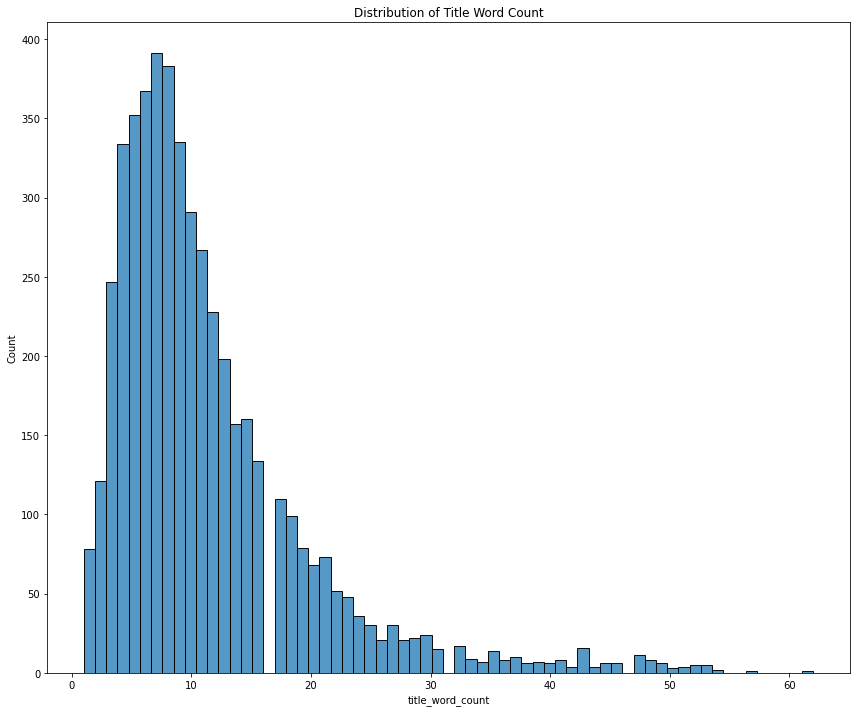

In [34]:
plt.figure(figsize = (12,10))
sns.histplot(data = all_posts["title_word_count"] )
plt.title('Distribution of Title Word Count')
plt.tight_layout()
plt.savefig('../visualizations /dist_twc_all.jpg', bbox_inches = 'tight');

This histogram shows the distribution of title word counts for all the posts we pulled from both subreddits. The distribution ranges from roughly 2 to 62, and is skewed to the right. 

In [35]:
religion_lens = all_posts[all_posts['subreddit'] == 1]
phil_lens = all_posts[all_posts['subreddit'] == 0]

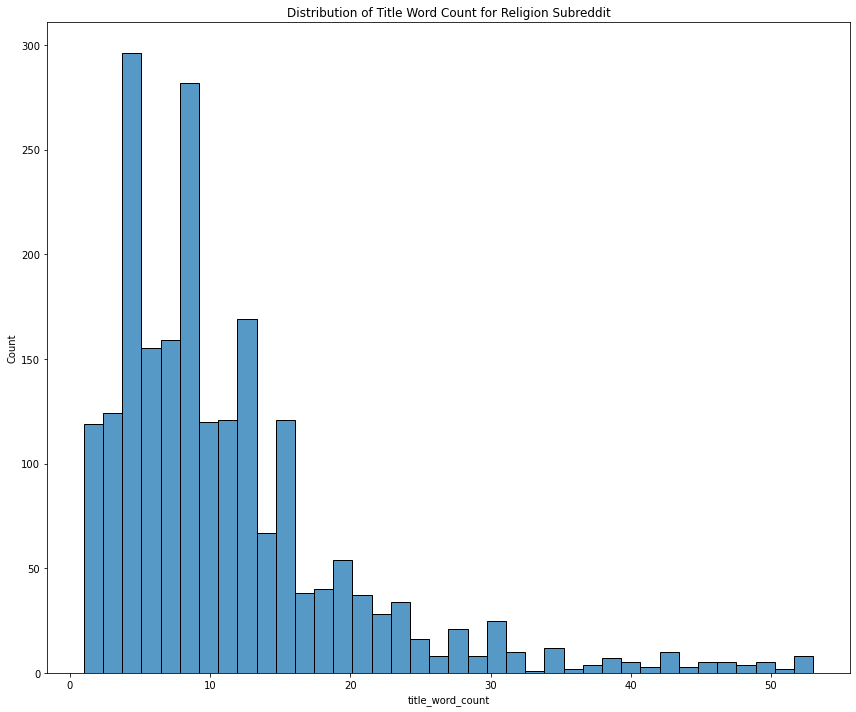

In [36]:
plt.figure(figsize = (12,10))
sns.histplot(data = religion_lens["title_word_count"] )
plt.title('Distribution of Title Word Count for Religion Subreddit')
plt.tight_layout()
plt.savefig('../visualizations /dist_twc_r.jpg', bbox_inches = 'tight');

This histogram shows the distribution of title word counts for posts from the Religion subreddit. The distribution ranges from roughly 2 to 52 and is skewed to the right. 

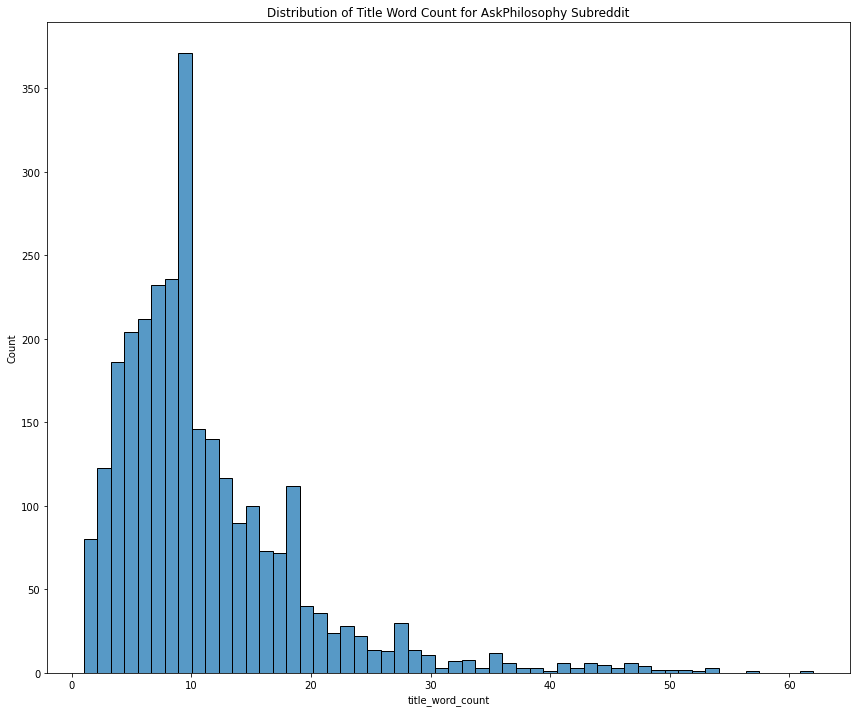

In [37]:
plt.figure(figsize = (12,10))
sns.histplot(data = phil_lens["title_word_count"] )
plt.title('Distribution of Title Word Count for AskPhilosophy Subreddit')
plt.tight_layout()
plt.savefig('../visualizations /dist_twc_p.jpg', bbox_inches = 'tight');

This histogram shows the distribution of title word counts for posts from the AskPhilosophy subreddit. The distribution ranges from roughly 2 to 62 and is skewed to the right. 

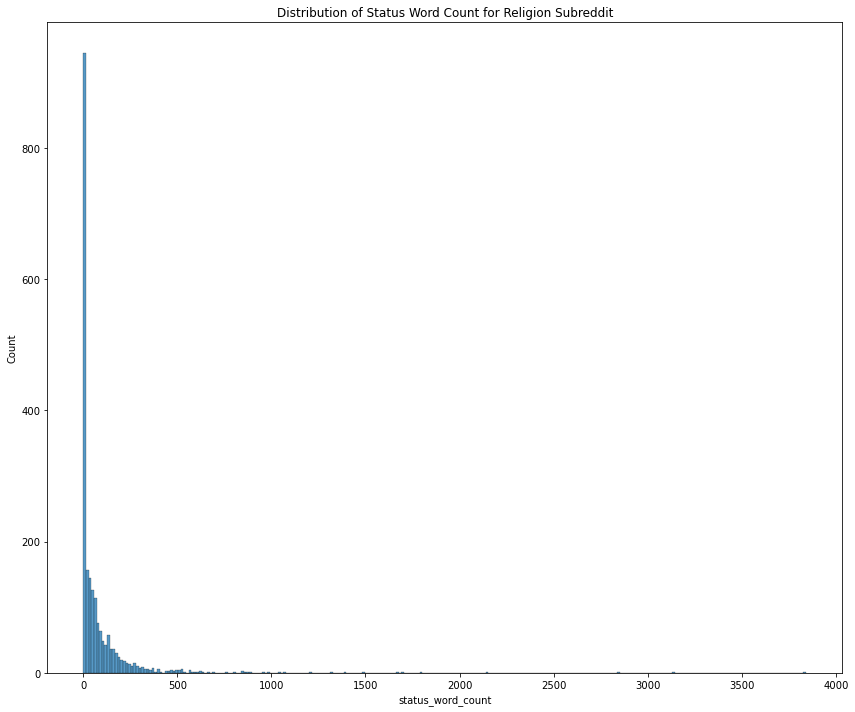

In [38]:
plt.figure(figsize = (12,10))
sns.histplot(data = religion_lens["status_word_count"] )
plt.title('Distribution of Status Word Count for Religion Subreddit')
plt.tight_layout()
plt.savefig('../visualizations /dist_swc_r.jpg', bbox_inches = 'tight');

This histogram shows the distribution of status word counts for posts from the Religion subreddit. The distribution ranges from roughly 0 to over 3500, is skewed to the right, and has a clear mode of 0. 

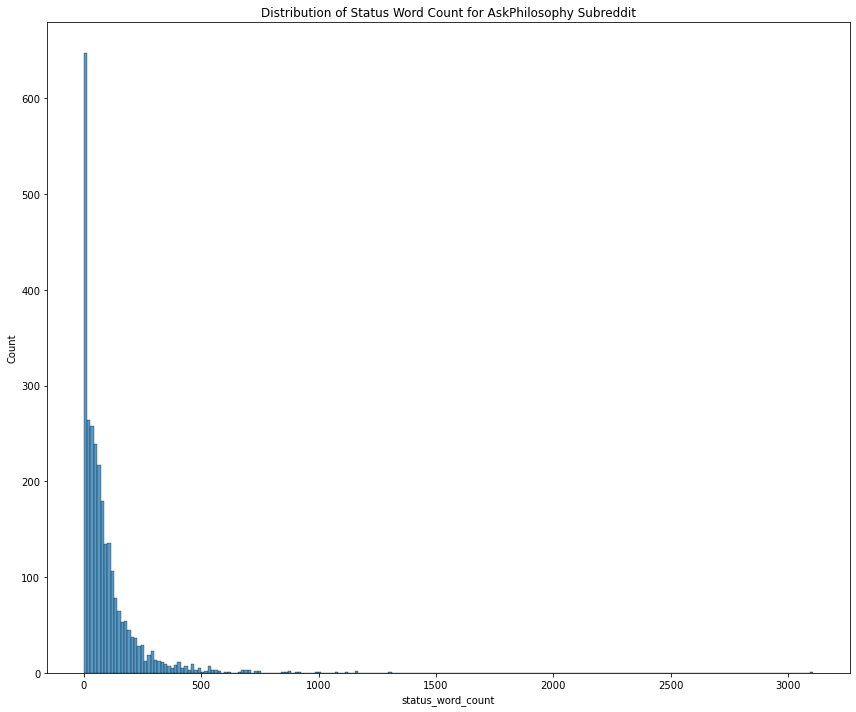

In [39]:
plt.figure(figsize = (12,10))
sns.histplot(data = phil_lens["status_word_count"] )
plt.title('Distribution of Status Word Count for AskPhilosophy Subreddit')
plt.tight_layout()
plt.savefig('../visualizations /dist_swc_p.jpg', bbox_inches = 'tight');

This histogram shows the distribution of status word counts for posts from the AskPhilosophy subreddit. The distribution ranges from roughly 0 to over 3000, is skewed to the right, and has a clear mode of 0. 

In [40]:
relphil_mean_sl = all_posts.groupby('subreddit').mean()['status_length']
relphil_mean_swc = all_posts.groupby('subreddit').mean()['status_word_count']
print(f' AskPhilosophy and Religion mean status length {relphil_mean_sl}')
print(f' AskPhilosophy and Religion status word count {relphil_mean_swc}')

 AskPhilosophy and Religion mean status length subreddit
0    565.799787
1    479.537124
Name: status_length, dtype: float64
 AskPhilosophy and Religion status word count subreddit
0    95.339368
1    82.792293
Name: status_word_count, dtype: float64


In [41]:
relphil_sl = pd.DataFrame(relphil_mean_sl, index = [0,1])
relphil_sl.head()

,status_length
0,565.799787
1,479.537124


In [42]:
relphil_sl['subreddit'] = ['AskPhilosophy', 'Religion']
relphil_sl.head()

,status_length,subreddit
0,565.799787,AskPhilosophy
1,479.537124,Religion


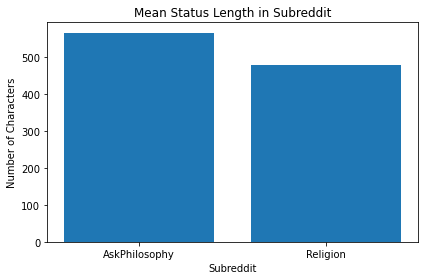

In [43]:
plt.title('Mean Status Length in Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Number of Characters')
plt.bar(relphil_sl['subreddit'], relphil_sl['status_length'])
plt.tight_layout()
plt.savefig('../visualizations /bar_msl.jpg', bbox_inches = 'tight');


This bar plot shows the mean status length for the AskPhilosophy and Religion subreddits. The mean status length for the AskPhilosophy subreddit is higher, around 570, while the mean status length for the religion subreddit is around 480. 

In [44]:
relphil_swc = pd.DataFrame(relphil_mean_swc, index = [0,1])

relphil_swc['subreddit'] = ['AskPhilosophy', 'Religion']
relphil_swc.head()

,status_word_count,subreddit
0,95.339368,AskPhilosophy
1,82.792293,Religion


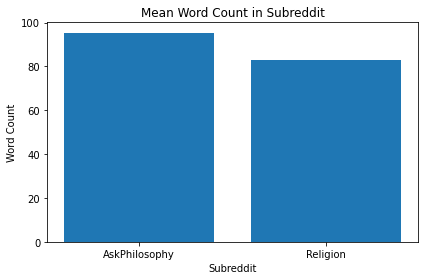

In [45]:
plt.title('Mean Word Count in Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Word Count')
plt.bar(relphil_swc['subreddit'], relphil_swc['status_word_count'])
plt.tight_layout()
plt.savefig('../visualizations /bar_mwc.jpg', bbox_inches = 'tight');

This bar plot shows the mean word count for the AskPhilosophy and Religion subreddits. The mean word count for the AskPhilosophy subreddit is higher, around 95, while the mean status length for the religion subreddit is around 80. 

In [46]:
all_posts['selftext'] = all_posts['selftext'].str.lower()
all_posts['title'] = all_posts['title'].str.lower()
all_posts.head()

,selftext,title,subreddit,status_length,status_word_count,title_len,title_word_count
0,,what would your first official act be if you r...,0,0,1,61,12
1,can’t find anything from google. there was an ...,does anyone have the review of camus’ the rebe...,0,308,52,91,18
2,i'm need to describe how they would handle foo...,what are characteristics of ecological constru...,0,112,20,55,6
3,"i can see how this cause would be eternal, nec...",how does the contingency argument show that th...,0,94,17,88,17
4,what was once a precious guideline has been di...,"from my very limited perspective, philosophy a...",0,123,19,108,18


In [47]:
all_posts['all_text'] = all_posts['selftext'] + all_posts['title']
all_posts.head()

,selftext,title,subreddit,status_length,status_word_count,title_len,title_word_count,all_text
0,,what would your first official act be if you r...,0,0,1,61,12,what would your first official act be if you r...
1,can’t find anything from google. there was an ...,does anyone have the review of camus’ the rebe...,0,308,52,91,18,can’t find anything from google. there was an ...
2,i'm need to describe how they would handle foo...,what are characteristics of ecological constru...,0,112,20,55,6,i'm need to describe how they would handle foo...
3,"i can see how this cause would be eternal, nec...",how does the contingency argument show that th...,0,94,17,88,17,"i can see how this cause would be eternal, nec..."
4,what was once a precious guideline has been di...,"from my very limited perspective, philosophy a...",0,123,19,108,18,what was once a precious guideline has been di...


##### Most Common Words

In [48]:
cvec= CountVectorizer(stop_words = 'english')
X=all_posts['all_text']
cvec.fit(X)
all_text_transform = cvec.transform(X)
all_text_cvec = pd.DataFrame(all_text_transform.todense(), columns = cvec.get_feature_names_out())

In [49]:
subreddit_df = all_posts[['subreddit']]
subreddit_df.reset_index(drop=True)

,subreddit
0,0
1,0
2,0
3,0
4,0
...,...
4940,1
4941,1
4942,1
4943,1


In [50]:
all_text_cvec

,00,000,00000001,000001,00022,000m,0010,00788r001700210016,01,010,...,ธรรมะ,บช,บทสวด,บทสวดมนต,มาละปะร,สอนใจ,อค,โพชฌ,ๆในการใช,ᴛʀᴜᴇ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
all_text_cvec['subreddit_class'] = subreddit_df['subreddit']
all_text_cvec.head()

,00,000,00000001,000001,00022,000m,0010,00788r001700210016,01,010,...,บช,บทสวด,บทสวดมนต,มาละปะร,สอนใจ,อค,โพชฌ,ๆในการใช,ᴛʀᴜᴇ,subreddit_class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [52]:
p = all_text_cvec[all_text_cvec['subreddit_class'] == 0]
p.head()

,00,000,00000001,000001,00022,000m,0010,00788r001700210016,01,010,...,บช,บทสวด,บทสวดมนต,มาละปะร,สอนใจ,อค,โพชฌ,ๆในการใช,ᴛʀᴜᴇ,subreddit_class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [53]:
p.sum().sort_values(ascending=False)[:10]

philosophy    1335.0
like          1063.0
just           898.0
people         866.0
does           835.0
know           722.0
think          675.0
don            606.0
question       577.0
life           559.0
dtype: float64

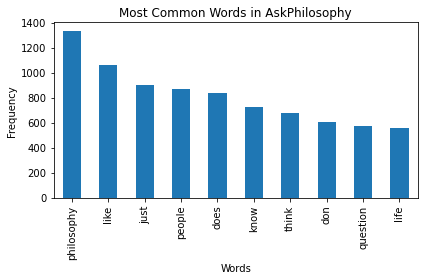

In [54]:
plt.title('Most Common Words in AskPhilosophy')
plt.ylabel('Frequency')
plt.xlabel('Words')
p.sum().sort_values(ascending=False)[:10].plot(kind='bar')
plt.tight_layout()
plt.savefig('../visualizations /p_most_common.jpg', bbox_inches = 'tight');

This bar chart shows the 10 most common words in the AskPhilosophy subreddit and their frequency. The 10 most common words are: philosophy, like, just, people, does, know, think, don (CountVectorizer splits on punctuation like ', so don likely was part of the word don't), question, life.

In [55]:
r = all_text_cvec[all_text_cvec['subreddit_class'] == 1]
r

,00,000,00000001,000001,00022,000m,0010,00788r001700210016,01,010,...,บช,บทสวด,บทสวดมนต,มาละปะร,สอนใจ,อค,โพชฌ,ๆในการใช,ᴛʀᴜᴇ,subreddit_class
2995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [56]:
r.drop(columns = ['subreddit_class'], inplace = True)

/var/folders/r1/szl7szs91f5bkjddv3cxyk8r0000gn/T/ipykernel_2226/2969731567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r.drop(columns = ['subreddit_class'], inplace = True)


In [57]:
r.sum().sort_values(ascending=False)[:10]

god          905
religion     678
people       585
like         519
just         485
don          386
believe      383
know         353
think        304
religious    303
dtype: int64

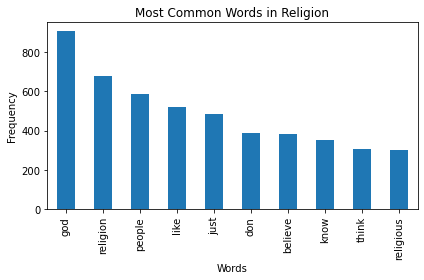

In [58]:
plt.title('Most Common Words in Religion')
plt.ylabel('Frequency')
plt.xlabel('Words')
r.sum().sort_values(ascending=False)[:10].plot(kind='bar')
plt.tight_layout()
plt.savefig('../visualizations /r_most_common.jpg', bbox_inches = 'tight');

This bar chart shows the 10 most common words in the Religion subreddit and their frequency. The 10 most common words are: god, religion, people, like, just, don (CountVectorizer splits on punctuation like ', so don likely was part of the word don't), believe, know, think, religious.

After EDA, it seems that there are going to be differences between the two subreddits that our model will be able to pick up on to predict which subreddit a submission came from. 

# Classification Models

#### Null Model

In [130]:
all_posts['subreddit'].value_counts(normalize=True)

0    0.569666
1    0.430334
Name: subreddit, dtype: float64

Our baseline accuracy is 57% if we classified every submission as AskPhilosophy

In [59]:
X = all_posts['all_text']
y = all_posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=222, stratify = y)

### Logistic Regression 

In [60]:
pipe_cvec_logreg = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(random_state = 222, max_iter=1000))
])

pipe_cvec_logreg_params = {
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [0.9, 1.0], 
    'logreg__solver': ['lbfgs', 'liblinear']
}

gs_cvec_logreg = GridSearchCV(pipe_cvec_logreg, pipe_cvec_logreg_params, n_jobs = -1)
gs_cvec_logreg.fit(X_train, y_train)

/Users/myacarrizosa/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=222))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 1.0],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None],
                         'logreg__solver': ['lbfgs', 'liblinear']})

Code adapted from General Assembly Lessons 4.04, 4.06, 5.05

In [61]:
gs_cvec_logreg.best_score_

0.8972503828511773

In [62]:
gs_cvec_logreg.best_params_

{'cvec__max_df': 0.9,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'logreg__solver': 'liblinear'}

In [111]:
print(f' Train accuracy: {gs_cvec_logreg.score(X_train, y_train)}, Test accuracy: {gs_cvec_logreg.score(X_test, y_test)}')

 Train accuracy: 0.9805825242718447, Test accuracy: 0.8932902182700081


In [64]:
y_pred_logreg = gs_cvec_logreg.predict(X_test)

In [65]:
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, y_pred_logreg).ravel()

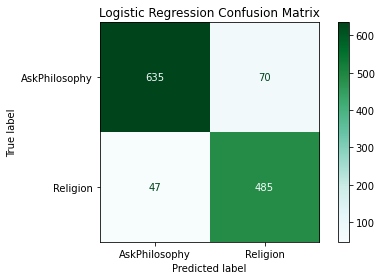

In [66]:
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_logreg),
                      display_labels=['AskPhilosophy', 'Religion']);
cmd.plot(cmap = 'BuGn')
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.savefig('../visualizations /lrcm.jpg', bbox_inches = 'tight');

This confusion matrix for our Logistic Regression model shows the number of posts that were correctly classified and misclassified. 635 posts were predicted to be from AskPhilosophy and were from AskPhilosophy, 70 posts were predicted to be from AskPhilosophy but were from Religion, 47 posts were predicted to be from Religion but were from AskPhilosophy, and 485 posts were predicted to be from Religion and were from Religion. 


Code adapted from General Assembly Lesson 4.03

In [110]:
#Sensitivity 
print(f' Sensitivity: {tp_lr / (tp_lr+fn_lr)}')
#Specificity
print(f' Specificity: {tn_lr / (tn_lr+fp_lr)}')
#Precision 
print(f' Precision: {tp_lr/(tp_lr+fp_lr)}')

 Sensitivity: 0.9116541353383458
 Specificity: 0.900709219858156
 Precision: 0.8738738738738738


### K Nearest Neighbors

In [68]:
X = all_posts['all_text']
y = all_posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=222, stratify = y)

In [69]:
#KNN
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss', StandardScaler(with_mean = False)),
    ('knn', KNeighborsClassifier())
])

pipe_cvec_knn_params = {
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [0.9, 1.0],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
    
}

gs_cvec_knn = GridSearchCV(pipe_cvec_knn, pipe_cvec_knn_params, n_jobs = -1)
gs_cvec_knn.fit(X_train, y_train)

/Users/myacarrizosa/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 1.0],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None],
                         'knn__metric': ['minkowski', 'euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']})

Code adapted from General Assembly Lesson 4.01, 4.06, 5.05

In [70]:
gs_cvec_knn.best_score_

0.5480071732306092

In [71]:
gs_cvec_knn.best_params_

{'cvec__max_df': 0.9,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'knn__metric': 'minkowski',
 'knn__n_neighbors': 3,
 'knn__weights': 'distance'}

In [112]:
print(f' Train accuracy: {gs_cvec_knn.score(X_train, y_train)}, Test accuracy: {gs_cvec_knn.score(X_test, y_test)}')

 Train accuracy: 0.999730312837109, Test accuracy: 0.5634599838318513


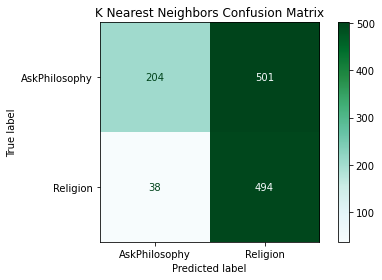

In [73]:
y_pred_knn = gs_cvec_knn.predict(X_test)
tn_k, fp_k, fn_k, tp_k = confusion_matrix(y_test, y_pred_knn).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_knn),
                      display_labels=['AskPhilosophy', 'Religion']);

cmd.plot(cmap = 'BuGn')
plt.title('K Nearest Neighbors Confusion Matrix')
plt.tight_layout()
plt.savefig('../visualizations /knncm.jpg', bbox_inches = 'tight');

This confusion matrix for our K Nearest Neighbors model shows the number of posts that were correctly classified and misclassified. 204 posts were predicted to be from AskPhilosophy and were from AskPhilosophy, 501 posts were predicted to be from AskPhilosophy but were from Religion, 38 posts were predicted to be from Religion but were from AskPhilosophy, and 494 posts were predicted to be from Religion and were from Religion. This model did much worse than the Logistic regression model at predicting the classification of posts from the AskPhilosophy subreddit.


Code adapted from General Assembly Lesson 4.03

In [113]:
#Sensitivity 
print(f' Sensitivity: {tp_k / (tp_k+fn_k)}')
#Specificity
print(f' Specificity: {tn_k / (tn_k+fp_k)}')
#Precision 
print(f' Precision: {tp_k/(tp_k+fp_k)}')

 Sensitivity: 0.9285714285714286
 Specificity: 0.28936170212765955
 Precision: 0.4964824120603015


### Random Forest

In [75]:
X = all_posts['all_text']
y = all_posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=222, stratify = y)

In [76]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state =222))
])

pipe_cvec_rf_params = {
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [0.9, 1.0],
    'rf__n_estimators': [100, 125, 150],
    'rf__max_depth': [3, 5, 8],
    'rf__min_samples_leaf': [1, 2, 5]
    
}

gs_cvec_rf = GridSearchCV(pipe_cvec_rf, pipe_cvec_rf_params, n_jobs = -1)
gs_cvec_rf.fit(X_train, y_train)

/Users/myacarrizosa/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=222))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 1.0],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None],
                         'rf__max_depth': [3, 5, 8],
                         'rf__min_samples_leaf': [1, 2, 5],
                         'rf__n_estimators': [100, 125, 150]})

Code adapted from General Assembly Lessons 4.06, 5.05, 6.03, 6.04

In [77]:
gs_cvec_rf.best_score_

0.7214094743389678

In [78]:
gs_cvec_rf.best_params_

{'cvec__max_df': 0.9,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'rf__max_depth': 8,
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 150}

In [114]:
print(f' Train accuracy: {gs_cvec_rf.score(X_train, y_train)}, Test accuracy: {gs_cvec_rf.score(X_test, y_test)}')

 Train accuracy: 0.7543149946062567, Test accuracy: 0.7299919159256265


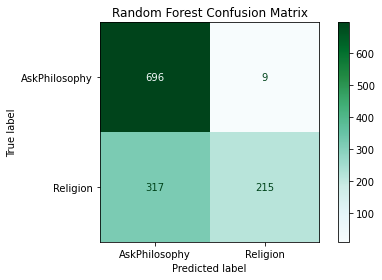

In [80]:
y_pred_rf = gs_cvec_rf.predict(X_test)
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf),
                      display_labels=['AskPhilosophy', 'Religion']);

cmd.plot(cmap = 'BuGn')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.savefig('../visualizations /rfcm.jpg', bbox_inches = 'tight');

This confusion matrix for our Random Forests model shows the number of posts that were correctly classified and misclassified. 696 posts were predicted to be from AskPhilosophy and were from AskPhilosophy, 9 posts were predicted to be from AskPhilosophy but were from Religion, 317 posts were predicted to be from Religion but were from AskPhilosophy, and 215 posts were predicted to be from Religion and were from Religion. This model seemed to have difficulty classifying posts that were from the Religion subreddit. 

Code adapted from General Assembly Lesson 4.03

In [115]:
#Sensitivity 
print(f' Sensitivity: {tp_rf / (tp_rf+fn_rf)}')
#Specificity
print(f' Specificity: {tn_rf / (tn_rf+fp_rf)}')
#Precision 
print(f' Pecision: {tp_rf/(tp_rf+fp_rf)}')

 Sensitivity: 0.4041353383458647
 Specificity: 0.9872340425531915
 Pecision: 0.9598214285714286


### Boosted Decision Trees (AdaBoost)

In [82]:
X = all_posts['all_text']
y = all_posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=222, stratify = y)

In [83]:
pipe_cvec_ada = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(random_state =222))
])

pipe_cvec_ada_params = {
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [0.9, 1.0],
    'ada__n_estimators': [100, 125, 150],
    'ada__learning_rate': [1.0, 1.5]
    
}

gs_cvec_ada = GridSearchCV(pipe_cvec_ada, pipe_cvec_ada_params, n_jobs = -1)
gs_cvec_ada.fit(X_train, y_train)

/Users/myacarrizosa/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(random_state=222))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [1.0, 1.5],
                         'ada__n_estimators': [100, 125, 150],
                         'cvec__max_df': [0.9, 1.0],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None]})

Code adapted from General Assembly Lessons 4.06, 5.05, 6.04

In [84]:
gs_cvec_ada.best_score_

0.8813346864985394

In [85]:
gs_cvec_ada.best_params_

{'ada__learning_rate': 1.0,
 'ada__n_estimators': 150,
 'cvec__max_df': 0.9,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [116]:
print(f' Train accuracy: {gs_cvec_ada.score(X_train, y_train)}, Test accuracy: {gs_cvec_ada.score(X_test, y_test)}')

 Train accuracy: 0.9096548004314995, Test accuracy: 0.872271624898949


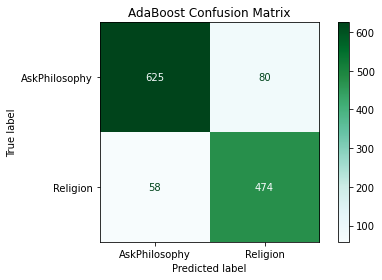

In [87]:
y_pred_ada = gs_cvec_ada.predict(X_test)
tn_ada, fp_ada, fn_ada, tp_ada = confusion_matrix(y_test, y_pred_ada).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_ada),
                      display_labels=['AskPhilosophy', 'Religion']);

cmd.plot(cmap = 'BuGn')
plt.title('AdaBoost Confusion Matrix')
plt.tight_layout()
plt.savefig('../visualizations /adacm.jpg', bbox_inches = 'tight');

This confusion matrix for our AdaBoost model shows the number of posts that were correctly classified and misclassified. 625 posts were predicted to be from AskPhilosophy and were from AskPhilosophy, 80 posts were predicted to be from AskPhilosophy but were from Religion, 58 posts were predicted to be from Religion but were from AskPhilosophy, and 474 posts were predicted to be from Religion and were from Religion. This model performed somewhat comparably to our Logistic Regression model.

Code adapted from General Assembly Lesson 4.03

In [117]:
#Sensitivity 
print(f' Sensitivity: {tp_ada / (tp_ada+fn_ada)}')
#Specificity
print(f' Specificity: {tn_ada / (tn_ada+fp_ada)}')
#Precision 
print(f' Precision: {tp_ada/(tp_ada+fp_ada)}')

 Sensitivity: 0.8909774436090225
 Specificity: 0.8865248226950354
 Precision: 0.855595667870036


### Removing Subreddit Names and Seeing Model Performance

In [89]:
banned = ['religion', 'philosophy']

In [90]:
all_posts["text_no_rp"] = [' '.join([item for item in x.split() 
                  if item not in banned]) 
                  for x in all_posts["all_text"]]

all_posts.head()

,selftext,title,subreddit,status_length,status_word_count,title_len,title_word_count,all_text,text_no_rp
0,,what would your first official act be if you r...,0,0,1,61,12,what would your first official act be if you r...,what would your first official act be if you r...
1,can’t find anything from google. there was an ...,does anyone have the review of camus’ the rebe...,0,308,52,91,18,can’t find anything from google. there was an ...,can’t find anything from google. there was an ...
2,i'm need to describe how they would handle foo...,what are characteristics of ecological constru...,0,112,20,55,6,i'm need to describe how they would handle foo...,i'm need to describe how they would handle foo...
3,"i can see how this cause would be eternal, nec...",how does the contingency argument show that th...,0,94,17,88,17,"i can see how this cause would be eternal, nec...","i can see how this cause would be eternal, nec..."
4,what was once a precious guideline has been di...,"from my very limited perspective, philosophy a...",0,123,19,108,18,what was once a precious guideline has been di...,what was once a precious guideline has been di...


This code has been adapted from https://stackoverflow.com/questions/51879018/removing-words-characters-from-string-in-dataframe-cell

In [131]:
X_no_rp = all_posts['text_no_rp']
y_no_rp = all_posts['subreddit']

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_no_rp, y_no_rp, random_state=222, stratify = y_no_rp)

In [132]:
pipe_no_rp = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_df=0.9, ngram_range = (1,1))),
    ('logreg', LogisticRegression(random_state = 222, max_iter=1000, solver = 'liblinear'))
])

pipe_no_rp.fit(X_train_n, y_train_n)

Pipeline(steps=[('cvec', CountVectorizer(max_df=0.9, stop_words='english')),
                ('logreg',
                 LogisticRegression(max_iter=1000, random_state=222,
                                    solver='liblinear'))])

Code adapted from General Assembly Lessons 4.01, 4.06, 5.05

In [133]:
print(f' Train accuracy: {pipe_no_rp.score(X_train_n, y_train_n)}, Test accuracy: {pipe_no_rp.score(X_test_n, y_test_n)}')

 Train accuracy: 0.9946062567421791, Test accuracy: 0.8957154405820533


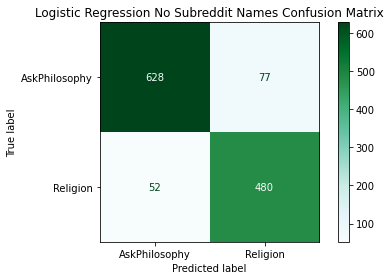

In [134]:
y_pred_lrns = pipe_no_rp.predict(X_test_n)
tn_lrns, fp_lrns, fn_lrns, tp_lrns = confusion_matrix(y_test_n, y_pred_lrns).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_n, y_pred_lrns),
                      display_labels=['AskPhilosophy', 'Religion']);

cmd.plot(cmap = 'BuGn')
plt.title('Logistic Regression No Subreddit Names Confusion Matrix')
plt.tight_layout()
plt.savefig('../visualizations /lr_no_names_cm.jpg', bbox_inches = 'tight');

This confusion matrix for our Logistic Regression model for posts with the words 'philosophy' and 'religion' removed shows the number of posts that were correctly classified and misclassified. 628 posts were predicted to be from AskPhilosophy and were from AskPhilosophy, 77 posts were predicted to be from AskPhilosophy but were from Religion, 52 posts were predicted to be from Religion but were from AskPhilosophy, and 480 posts were predicted to be from Religion and were from Religion. 

Code adapted from General Assembly Lesson 4.03

In [135]:
#Sensitivity 
print(f' Sensitivity: {tp_lrns / (tp_lrns+fn_lrns)}')
#Specificity
print(f' Specificity: {tn_lrns / (tn_lrns+fp_lrns)}')
#Precision 
print(f' Precision: {tp_ada/(tp_lrns+fp_lrns)}')

 Sensitivity: 0.9022556390977443
 Specificity: 0.8907801418439716
 Precision: 0.8509874326750448


## Misclassifications

In [96]:
classifications = y_test.to_frame()
classifications['predictions'] = y_pred_lrns
classifications.head()

,subreddit,predictions
4124,1,1
5548,1,1
570,0,0
5027,1,1
5863,1,1


In [97]:
classifications[classifications['subreddit'] != classifications['predictions']]

,subreddit,predictions
5689,1,0
1123,0,1
4292,1,0
5168,1,0
985,0,1
...,...,...
2171,0,1
4600,1,0
2927,0,1
2648,0,1


In [98]:
classifications['difference'] = classifications['subreddit'] - classifications['predictions']
classifications.head()

,subreddit,predictions,difference
4124,1,1,0
5548,1,1,0
570,0,0,0
5027,1,1,0
5863,1,1,0


In [99]:
misclass = classifications[classifications['difference'] != 0]

In [100]:
misclass.shape

(129, 3)

In [ ]:
misclass['predictions'].iloc[]

In [101]:
misclass.head()

,subreddit,predictions,difference
5689,1,0,1
1123,0,1,-1
4292,1,0,1
5168,1,0,1
985,0,1,-1


In [124]:
all_posts['text_no_rp'].iloc[4292]

'https://youtu.be/epcy3huo6hya video essay i made on jehovah’s witnesses. tell me what you think!'

In [102]:
all_posts['text_no_rp'].iloc[2694]

"why items highly subsidized by the government are expensive? shouldn't subsidy reduce price? https://www.reddit.com/r/differentangle/comments/w9kze3/items_highly_subsidized_by_the_government_are/?utm_medium=android_app&amp;utm_source=shareitems highly subsidized by the government are highlighted."

In [103]:
all_posts['text_no_rp'].iloc[1123]

"does 'justice' require that wrongdoers suffer, and suffer in proportion to the level of wrongness of their offense?do people deserve to suffer for their evil actions?"

In [104]:
all_posts['text_no_rp'].iloc[1297]

'is this an unfounded assertion or is there substance to this claim? if so where can i learn about it more?is “no effect can be greater than its cause” true?'

In [105]:
all_posts['text_no_rp'].iloc[2173]

"alright, before i get mass downvoted for trying to demonize or straw man atheism: i am an atheist. i believe there is no god and that evolution through natural selection is the means by which we exist. but i'm just struggling with the concept of meaning. obviously, humans have a complicated society, which is filled with relationships, economics, recreation, transportation, jobs, experiences, etcetera. but although that provides fulfillment, aren't we just here to have pass on our genes and that's all that matters? don't get me wrong, i understand that life has so many nuances, varying factors, and emotions, which people definitely derive what they see as meaning from, but in the end isn't the only thing that matters in terms of species just reproductive success? i know there were bad people throughout history who did terrible things, yet had children. no matter how godawful they may be, and no matter what terrible things they've done, in the grand scheme of things haven't they achieve

In [106]:
all_posts['text_no_rp'].iloc[985]

'what did feuerbach mean in this quote from the preface to the second edition of \'the essence of christianity\' when he said "but certainly for the present age, which prefers the sign to the thing signified, the copy to the original, fancy to reality . . . . illusion only is sacred, truth profane. nay sacredness is held to be enhanced in proportion as truth decreases and illusion increases, so that the highest degree of illusion comes to be the highest degree of sacredness." at a surface level, it\'s obvious that feuerbach is claiming the present age prefers copies over the original. what is his basis for saying this? surely, when i walk into a pawn shop i want the oldest and most original and sacred coin possible for thr value of my item would dramtically increase. i understand feuerbach is not speaking in this same context but what context might he be speaking in?ludwig feuerbach quote breakdown'